In [61]:
#This code was give in the site give in the project description
#This function uses the pickle library to convert the
#serialized binary data to a dictionary format
#(key -> object_name, values -> images in tensor form)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



In [62]:
import numpy as np

# Initialize empty lists to store data and labels from each batch
train_images_list = []
train_labels_list = []

# Loop through each train batch
for i in range(1, 6):  # Batches are numbered 1 to 5
    # Load data from the current batch
    train_data = unpickle(f"data_batch_{i}")

    train_images_list.append(np.array(train_data[b"data"]))

    train_labels_list.append(np.array(train_data[b"labels"]))

# Concatenate all batch data into a single array
train_images = np.concatenate(train_images_list, axis=0)

# Concatenate all batch labels into a single array
train_labels = np.concatenate(train_labels_list, axis=0)

print(f"data -> {train_images.shape}")
print(f"labels -> {train_labels.shape}")

#Load test data
test_data = unpickle("test_batch")
test_images = np.array(test_data[b"data"])  # Shape: (10000, 3072)
test_labels = np.array(test_data[b"labels"])  # Shape: (10000,)

print(f"data -> {test_images.shape}")
print(f"labels -> {test_labels.shape}")

# Reshape images to (N, 32, 32, 3)
train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print("Training set shape:", train_images.shape)  # (50000, 32, 32, 3)
print("Test set shape:", test_images.shape)  # (10000, 32, 32, 3)

#as per the site the meta file in the folder contains class names so loading and checking

meta_data = unpickle("batches.meta")

class_names = [name.decode("utf-8") for name in meta_data[b"label_names"]]
print(class_names)



data -> (50000, 3072)
labels -> (50000,)
data -> (10000, 3072)
labels -> (10000,)
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


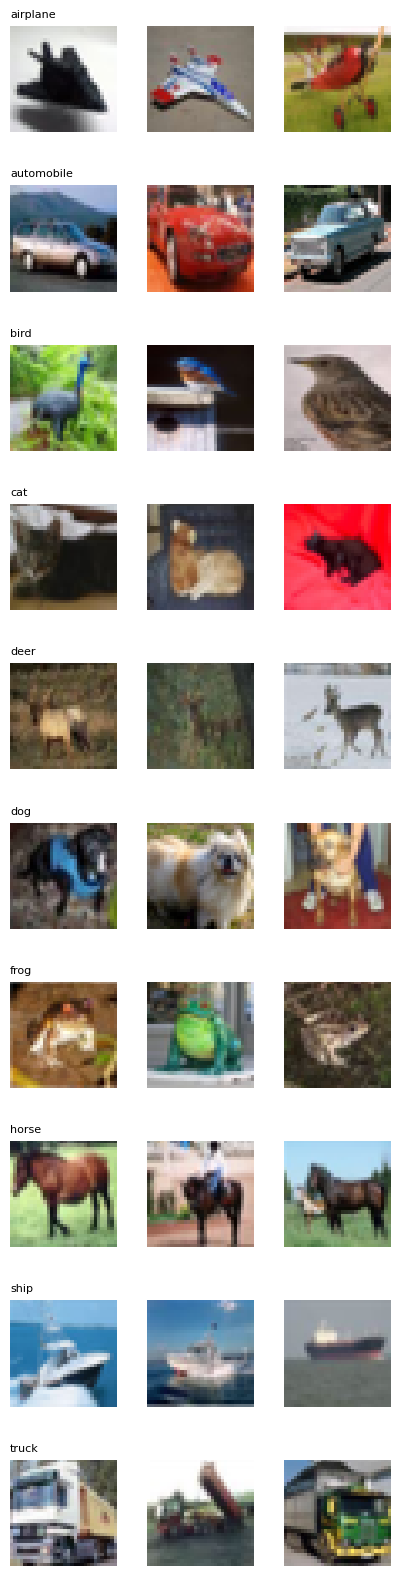

In [63]:
#visulizing and cross checking the data for further applications
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 3, figsize=(5, 20))  # 10 rows (classes), 3 columns (images per class)
plt.subplots_adjust(hspace=0.5)

for i in range(10):  # Loop through 10 classes
    class_indices = np.where(train_labels == i)[0]  # Find indices of this class
    selected_images = class_indices[:3]  # Pick first 3 images of this cass

    for j, img_idx in enumerate(selected_images):
        ax = axes[i, j]
        ax.imshow(train_images[img_idx])
        ax.axis("off")
        if j == 0:  # Add label only to the first image in each row
            ax.set_title(class_names[i], fontsize=8, loc='left')

plt.show()

In [64]:
#working on 32 * 32 * 3 data could make computations large and time complexity in case of some algos like knn and lr
#increases drastically so applying dimensionality reduction by feature extraction using PCA

#scratch code of applying PCA on the above data
def principal_components(images,variance_ratio = 0.9):
  #PCA works on 2-D data so flattening the tensors i created
  N, H, W, C = images.shape  # (N, 32, 32, 3)
  flattened_images = images.reshape(N, -1)  # Shape: (N, 3072)


  #Step - 1 - Mean centre and stardize the data z= x - u/sigma
  mean = np.mean(flattened_images, axis=0)  # Mean of each feature
  std = np.std(flattened_images, axis=0) + 1e-10  # Avoid division by zero
  standardized_images = (flattened_images - mean) / std

  #Step -2 -> Computing the co-variance matrix
  covariance_matrix = np.cov(standardized_images, rowvar=False)  # Shape: (3072, 3072)

  #Step - 3 -> calculating the eigen valiues and vector directly by using the numpy lib
  eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)  # eigh() for symmetric matrices

  #eigen values(it shows the weight of the eigen vector in explaining the output),
  #hence arranging the eigen vals and their corresponding vectors in decending order
  sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort eigenvalues in descending order
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectors = eigenvectors[:, sorted_indices]  # Eigenvectors sorted accordingly

# Step- 4 -> Finding the optimal no. of features for explaing the variance_ratio fraction of data
  total_variance = np.sum(eigenvalues)
  explained_variance = np.cumsum(eigenvalues) / total_variance  # Cumulative variance ratio

  # Find minimum number of components where explained_variance >= variance_ratio
  optimal_components = np.argmax(explained_variance >= variance_ratio) + 1  # 1-based index

  print("Initially the data has 32*32*3 features ,3072")
  print(f"Optimal number of features for {variance_ratio * 100}% variance: {optimal_components}")

  # Select the top eigenvectors
  top_eigenvectors = eigenvectors[:, :optimal_components]  # Selecting the top components
  return mean, std, top_eigenvectors

def transform(images, mean, std, top_ev):
    # Flatten images
    N = images.shape[0]
    flattened_images = images.reshape(N, -1)

    # Standardize using training mean & std (z = (x - mu )/ sigma)
    standardized_images = (flattened_images - mean) / std

    # Project onto top eigenvectors
    reduced_data = np.dot(standardized_images, top_ev)

    return reduced_data

variance_ratio = 0.95  # 95% variance explained
mean, std_deviation, top_eigenvectors = principal_components(train_images, variance_ratio)

train_pca = transform(train_images, mean, std_deviation, top_eigenvectors)
test_pca = transform(test_images, mean, std_deviation, top_eigenvectors)
print(f"train_pca -> {train_pca.shape}")
print(f"test_pca -> {test_pca.shape}")

Initially the data has 32*32*3 features ,3072
Optimal number of features for 95.0% variance: 221
train_pca -> (50000, 221)
test_pca -> (10000, 221)


In [65]:
def calculate_mean_variance(X, y):
    """
    Calculate the mean, variance, and prior probabilities for each class.
    """
    classes = np.unique(y)
    mean = {}
    var = {}
    priors = {}
    for cls in classes:
        X_cls = X[y == cls]
        mean[cls] = np.mean(X_cls, axis=0)
        var[cls] = np.var(X_cls, axis=0)
        priors[cls] = X_cls.shape[0] / X.shape[0]
    return mean, var, priors, classes

In [66]:
def gaussian_probability(x, mean, var):
    """
    Calculate the Gaussian probability density function.
    """
    eps = 1e-6  # To avoid division by zero
    coeff = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
    exponent = np.exp(-((x - mean) ** 2) / (2.0 * var + eps))
    return coeff * exponent

In [67]:
def calculate_posterior(data_point, prior_probs, likelihoods):
    """
    Calculates posterior probability for a data point.

    Args:
        data_point: A single data point.
        prior_probs: Dictionary of prior probabilities for each class.
        likelihoods: Dictionary of likelihood parameters for each class.

    Returns:
        Dictionary mapping class labels to their posterior probabilities for the given data point.
    """
    posterior_probs = {}
    for class_label, prior_prob in prior_probs.items():
        mean, std = likelihoods[class_label]
        likelihood = np.prod(1 / (np.sqrt(2 * np.pi) * std) * np.exp(-((data_point - mean)**2) / (2 * (std**2))))
        posterior_probs[class_label] = likelihood * prior_prob
    return posterior_probs

In [68]:
def calculate_likelihood(x, mean, var):
    """
    Calculate the likelihood for a given sample.
    """
    likelihood = np.sum(np.log(gaussian_probability(x, mean, var)))
    return likelihood

In [69]:
def calculate_posterior(x, mean, var, priors, classes):
    """
    Calculate the posterior probabilities for all classes for a given sample.
    """
    posteriors = {}
    for cls in classes:
        prior = np.log(priors[cls])
        likelihood = calculate_likelihood(x, mean[cls], var[cls])
        posteriors[cls] = prior + likelihood
    return posteriors

In [70]:
def predict(X, mean, var, priors, classes):
    """
    Predict the class labels for the input data.
    """
    predictions = []
    for x in X:
        posteriors = calculate_posterior(x, mean, var, priors, classes)
        predictions.append(max(posteriors, key=posteriors.get))
    return np.array(predictions)

In [ ]:
# Train the model
mean, var, priors, classes = calculate_mean_variance(train_pca, train_labels)

# Predict the labels for the test and train data
test_predictions = predict(test_pca, mean, var, priors, classes)
train_predictions = predict(train_pca, mean, var, priors, classes)

# Calculate accuracy on the train set
train_accuracy = np.mean(train_predictions == train_labels)
print("Train set Accuracy of Gaussian Naive Bayes classifier:", train_accuracy)

# Calculate accuracy on the test set
test_accuracy = np.mean(test_predictions == test_labels)
print("Test set Accuracy of Gaussian Naive Bayes classifier:", test_accuracy)

Improved Accuracy of Gaussian Naive Bayes classifier: 0.3031
